In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from experiments.VizReconstructionUtils import plot_cells
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from lib.Curves.CurvePolynomial import CurveLinearAngle
from sklearn.neural_network import MLPRegressor
from experiments.LearningMethods import flatter, skkeras_20x20_relu, skkeras_20x20_relu_noisy
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from lib.DataManagers.LearningMethodManager import LearningMethodManager
import config
from lib.DataManagers.DatasetsManagers.DatasetsManagerLinearCurves import DatasetsManagerLinearCurves, ANGLE_OBJECTIVE
from lib.DataManagers.DatasetsManagers.DatasetsBaseManager import get_averages_from_curve_kernel, FLUX_PROBLEM, \
    get_flux_from_curve_and_velocity



2023-10-26 14:12:51.927210: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 14:12:52.792020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:

N = int(1e6)
dataset_manager_3_8pi = DatasetsManagerLinearCurves(
    velocity_range=[(0, 1 / 4), (1 / 4, 0)], path2data=config.data_path, N=N, kernel_size=(3, 3), min_val=0, max_val=1,
    workers=15, recalculate=False, learning_objective=ANGLE_OBJECTIVE, angle_limits=(-3 / 8, 3 / 8),
    value_up_random=True
)


 -> duracion Loading trained model: Flux_Flatter_NN_CurveLinearAngle_k3_3_n1000000_min0_max1_v0_025_025_0_AngleLimits-0.375pi0.375pi_radius1_n_train900000_noise0: 0.00s
 -> duracion Loading trained model: Flux_Flatter_SKKerasFNN20x20_CurveLinearAngle_k3_3_n1000000_min0_max1_v0_025_025_0_AngleLimits-0.375pi0.375pi_radius1_n_train900000_noise0: 0.00s
 -> duracion Loading data from /home/callum/Repos/GitHub/SubCellResolution/Data/Dataset4Learning_CurveLinearAngle_k3_3_n1000000_min0_max1_v0_025_025_0_AngleLimits-0375pi0375pi_radius1.compressed: 116.78s
Training model: noisy_Flux_Flatter_SKKerasFNN20x20_CurveLinearAngle_k3_3_n1000000_min0_max1_v0_025_025_0_AngleLimits-0.375pi0.375pi_radius1_n_train900000_noise0

/home/callum/Repos/GitHub/SubCellResolution/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1617: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/callum/Repos/GitHub/SubCellResolution/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
2023-10-26 14:14:57.397058: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


0epoch [00:00, ?epoch/s]

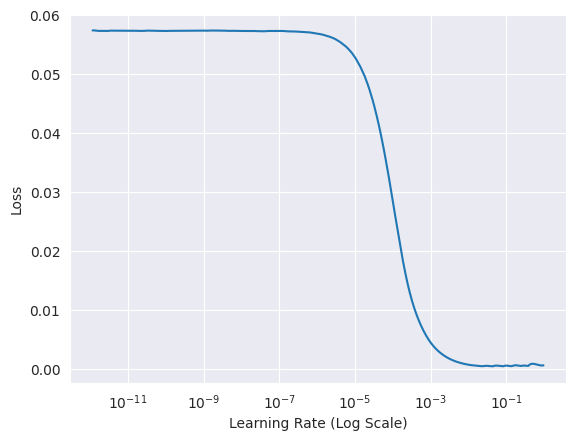

Restart number: 0


0epoch [00:00, ?epoch/s]

Restoring model weights from the end of the best epoch: 4471.
Epoch 4571: early stopping
Models min validation loss:  [2.2533977244165726e-06]
 -> duracion Training model: noisy_Flux_Flatter_SKKerasFNN20x20_CurveLinearAngle_k3_3_n1000000_min0_max1_v0_025_025_0_AngleLimits-0.375pi0.375pi_radius1_n_train900000_noise0: 572.69s
L1 Loss in train set: 0.00106964762709074
Linf Loss in train set: 0.012567523634214178
L1 Loss in test set: 0.001066947856075138
Linf Loss in test set: 0.012119570549382303


In [4]:


nnlm = LearningMethodManager(
    dataset_manager=dataset_manager_3_8pi,
    type_of_problem=FLUX_PROBLEM,
    trainable_model=Pipeline(
        [
            ("Flatter", FunctionTransformer(flatter)),
            ("NN", MLPRegressor(hidden_layer_sizes=(20, 20,), activation='relu', learning_rate_init=0.1,
                                learning_rate="adaptive", solver="adam"))
        ]
    ),
    refit=False, n2use=-1,
    train_percentage=0.9
)


nnlmkeras = LearningMethodManager(
    dataset_manager=dataset_manager_3_8pi,
    type_of_problem=FLUX_PROBLEM,
    trainable_model=skkeras_20x20_relu,
    refit=False, n2use=-1,
    train_percentage=0.9
)

nnlmkeras_noisy = LearningMethodManager(
    name="noisy_",
    dataset_manager=dataset_manager_3_8pi,
    type_of_problem=FLUX_PROBLEM,
    trainable_model=skkeras_20x20_relu_noisy,
    refit=True, n2use=-1,
    train_percentage=0.9
)

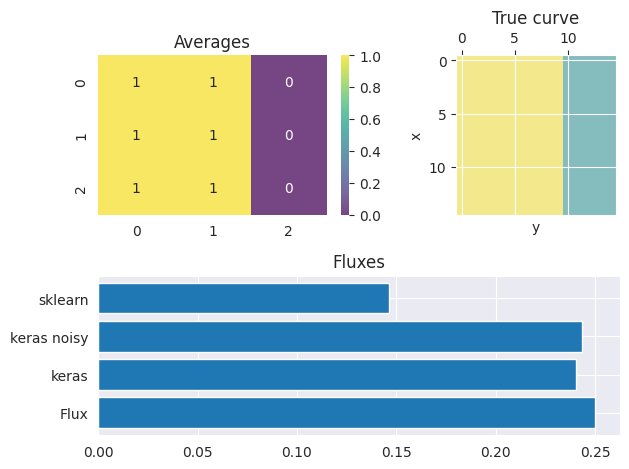

In [10]:

kernel_size = (3, 3)
angle = 0.0
y0 = 0.5
velocity = (0.25, 0)
velocity = (0.0, 0.25)
value_up = 0
value_down = 1
refinement = 5

curve = CurveLinearAngle(angle, y0, value_up, value_down, x_shift=0)
kernel = get_averages_from_curve_kernel(kernel_size, curve, center_cell_coords=None)
u = get_evaluations2test_curve(curve, kernel_size, refinement=refinement)
flux = get_flux_from_curve_and_velocity(curve, center_cell_coords=np.array(kernel_size) // 2, velocity=velocity)[0]
_, pred_flux = nnlm.predict_flux(kernel, velocity)
_, pred_flux_k = nnlmkeras.predict_flux(kernel, velocity)
_, pred_flux_kn = nnlmkeras_noisy.predict_flux(kernel, velocity)

fig = plt.figure()
ax = fig.add_gridspec(6, 5)
ax1 = fig.add_subplot(ax[:3, 0:3])
ax1.set_title('Averages')
ax2 = fig.add_subplot(ax[:3, 3:])
ax2.set_title('True curve')
ax3 = fig.add_subplot(ax[3:, :])
ax3.set_title('Fluxes')

sns.heatmap(kernel, annot=True, cmap="viridis", alpha=0.7, ax=ax1)
plot_cells(ax=ax2, colors=u, mesh_shape=np.array(kernel_size) * refinement, alpha=0.5,
           cmap="viridis",
           vmin=-1, vmax=1)
ax3.barh(["Flux", "keras", 
          "keras noisy", 
          "sklearn"], [flux, pred_flux_k, 
                                                       pred_flux_kn, 
                                                       pred_flux, ])
plt.tight_layout()